In [4]:
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import olympus 
from olympus.surfaces import Surface
import sobol_seq

from scipy.stats import pearsonr, spearmanr

import GPy



from olympus.surfaces import AbstractSurface
from itertools import product



from neural_processes.utils.synthetic_data import metaBO_factory

In [5]:
# GOLDSTEIN-PRICE =====================================================
def gprice(x):
    # the goldstein price function (2D)
    # https://www.sfu.ca/~ssurjano/goldpr.html
    x1 = x[:, 0]
    x2 = x[:, 1]

    # scale x
    x1 = x1 * 4.
    x1 = x1 - 2.
    x2 = x2 * 4.
    x2 = x2 - 2.

    gprice = (1 + (x1 + x2 + 1) ** 2 * (19 - 14 * x1 + 3 * x1 ** 2 - 14 * x2 + 6 * x1 * x2 + 3 * x2 ** 2)) * \
             (30 + (2 * x1 - 3 * x2) ** 2 * (18 - 32 * x1 + 12 * x1 ** 2 + 48 * x2 - 36 * x1 * x2 + 27 * x2 ** 2))

    # lognormalize
    mean = 8.693
    std = 2.427
    gprice = 1 / std * (np.log(gprice) - mean)

    # maximize
    gprice = -gprice

    return gprice.reshape(x.shape[0], 1)


def gprice_max_min():
    max_pos = np.array([[0.0, -1.0]])
    max_pos[0, 0] += 2.
    max_pos[0, 0] /= 4.
    max_pos[0, 1] += 2.
    max_pos[0, 1] /= 4.
    max = gprice(max_pos)

    min_pos = np.array([[0.066, 1.0]])
    min = gprice(min_pos)

    return max_pos, max, min_pos, min


def gprice_var(x, t, s):
    x_new = x.copy()
    # apply translation
    # clip the translations s.t. upper left max lies in domain
    t_range = np.array([[-0.5, 0.5],
                        [-0.25, 0.75]])
    t = np.clip(t, t_range[:, 0], t_range[:, 1])
    x_new = x_new - t

    return s * gprice(x_new)


def gprice_max_min_var(t, s):
    # do the transformation in opposite order as in hm3_var!

    max_pos, max, min_pos, min = gprice_max_min()

    # apply translation
    t_range = np.array([[-0.5, 0.5],
                        [-0.25, 0.75]])
    t = np.clip(t, t_range[:, 0], t_range[:, 1])
    max_pos = max_pos + t
    min_pos = min_pos + t

    return max_pos, s * max, min_pos, s * min



def hm3(x):
    # the hartmann3 function (3D)
    # https://www.sfu.ca/~ssurjano/hart3.html
    # parameters
    alpha = np.array([1.0, 1.2, 3.0, 3.2])
    A = np.array([[3.0, 10, 30],
                  [0.1, 10, 35],
                  [3.0, 10, 30],
                  [0.1, 10, 35]])
    P = 1e-4 * np.array([[3689, 1170, 2673],
                         [4699, 4387, 7470],
                         [1091, 8732, 5547],
                         [381, 5743, 8828]])
    x = x.reshape(x.shape[0], 1, -1)
    B = x - P
    B = B ** 2
    exponent = A * B
    exponent = np.einsum("ijk->ij", exponent)
    C = np.exp(-exponent)
    hm3 = -np.einsum("i, ki", alpha, C)
    # normalize
    mean = -0.93
    std = 0.95
    hm3 = 1 / std * (hm3 - mean)
    # maximize
    #hm3 = -hm3
    return hm3.reshape(x.shape[0], 1)
def hm3_max_min():
    max_pos = np.array([[0.114614, 0.555649, 0.852547]])
    max = hm3(max_pos)
    min_pos = np.array([[1.0, 1.0, 0.0]])
    min = hm3(min_pos)
    return max_pos, max, min_pos, min
def hm3_var(x, t, s):
    x_new = x.copy()
    # apply translation
    # clip the translations s.t. upper left max lies in domain
    t_range = np.array([[-0.11, 0.88],
                        [-0.55, 0.44],
                        [-0.85, 0.14]])
    t = np.clip(t, t_range[:, 0], t_range[:, 1])
    x_new = x_new - t
    return s * hm3(x_new)
def hm3_max_min_var(t, s):
    # do the transformation in opposite order as in hm3_var!
    max_pos, max, min_pos, min = hm3_max_min()
    # apply translation
    t_range = np.array([[-0.11, 0.88],
                        [-0.55, 0.44],
                        [-0.85, 0.14]])
    t = np.clip(t, t_range[:, 0], t_range[:, 1])
    max_pos = max_pos + t
    min_pos = min_pos + t
    return max_pos, s * max, min_pos, s * min


In [6]:
class OlympTransform():
    def __init__(self, surf_name, param_dim, num_opts=21):
        
        self.surf_name = surf_name
        self.param_dim = param_dim
        self.num_opts = num_opts
        self.surface = Surface(kind=self.surf_name, param_dim=self.param_dim, num_opts=num_opts)
        
    def run(self, x):
        return np.array(self.surface.run(x))
        
    def var(self, x, t, s):
        x_new = x.copy()
        # apply translation
        # clip the translations s.t. upper left max lies in domain
#         t_range = np.array([[-0.12, 0.87],
#                             [-0.81, 0.18]])
#         t = np.clip(t, t_range[:, 0], t_range[:, 1])
        x_new = x_new - t

        return s * self.run(x_new)

    
    def max_min(self):
        
        minima = self.surface.minima
        maxima = self.surface.maxima
        
        min_x = np.array([m['params'] for m in minima])
        min_y = np.array([[m['value']] for m in minima])
        
        max_x = np.array([m['params'] for m in maxima])
        max_y = np.array([[m['value']] for m in maxima])
        
        return max_x, max_y, min_x, min_y
    
    
    def min_max_var(self, t, s):
        min_x, min_y, max_x, max_y = self.max_min()
        
#         # apply translation
#         t_range = np.array([[-0.5, 0.5],
#                         [-0.25, 0.75]])
#         t = np.clip(t, t_range[:, 0], t_range[:, 1])
        max_x = max_x + t
        min_x = min_x + t
        
        return max_x, s*max_y, min_x, s*min_y
        
    
  
        


In [7]:
trans = OlympTransform('Dejong', 3)

trans.max_min()
x = np.array([[0.5, 0.5, 0.5]])
s = trans.run(x)


In [8]:
trans = OlympTransform('CatDejong', param_dim=2, num_opts=21)
trans.run(['x0', 'x1'])

array([[47.448064]])

In [9]:
#!/usr/bin/env python

import numpy as np


from olympus.surfaces import AbstractSurface
from itertools import product


class CatMichalewiczVar(AbstractSurface):

    """
    The Michalewicz surface is generalized to categorical spaces from the Michalewicz function. This surface features well-defined options for each dimension which yield significantly better performances than
    others. In addition, the number of pseudo-local minima scales factorially with the number of dimensions

    Michalewicz is to be evaluated on the hypercube
    x_i in [0, pi] for i = 1, ..., d
    """
    def __init__(self, param_dim, num_opts, descriptors=None):
        '''
        '''
        AbstractSurface.__init__(param_type='categorical', **locals())


    @property
    def minima(self):
        return None

    @property
    def maxima(self):
        return None


    def michalewicz(self, vector, m = 10.):
        result = 0.
        for index, element in enumerate(vector):
            result += - np.sin(element) * np.sin( (index + 1) * element**2 / np.pi)**(2 * m)
        return result
    
    def michalewicz_var(self, vector, t, s, m = 10.):
     
        x_new = vector.copy()
        x_new = x_new - t
        return s* self.michalewicz(x_new)

    def run_var(self, params, t, s):
        # map the sample onto the unit hypercube
        vector = np.zeros(self.param_dim)
        for index, element in enumerate(params):
            # make a messy check to see if the user passes integerts or
            # strings representing the categories
            # we expect either a int here, e.g. 12 or str of form e.g. 'x12'
            if isinstance(element, str):
                element = int(element[1:])
            elif isinstance(element, int):
                pass
            # TODO: add else statement here and return error
            vector[index] = np.pi * element / float(self.num_opts - 1)
        return self.michalewicz_var(vector, t, s)

    def _run(self):
        return None

In [10]:
class CatCamelVar(AbstractSurface):

    """
    The Camel surface is generalized from the Camel function on continuous domains and features
    a degenerate and pseudo-disconnected global minimum

    Camel is to be evaluated on the hypercube
        x_i in [-3, 3] for i = 1, ..., d
    """
    def __init__(self, param_dim, num_opts, descriptors=None):
        ''' descriptors must be an iterable with the length num_opts

        For these surfaces, the same descriptors are used for each dimension
        '''
        AbstractSurface.__init__(param_type='categorical', **locals())

    @property
    def minima(self):
        # TODO: these are only the 2d values

        return None

    @property
    def maxima(self):
        # TODO: these are only the 2d values
        return None

    def camel(self, vector):
        result = 0.
        # global minima
        loc_0 = np.array([-1., 0.])
        loc_1 = np.array([ 1., 0.])
        weight_0 = np.array([4., 1.])
        weight_1 = np.array([4., 1.])

        # local minima
        loc_2  = np.array([-1., 1.5])
        loc_3  = np.array([ 1., -1.5])
        loc_5  = np.array([-0.5, -1.0])
        loc_6  = np.array([ 0.5,  1.0])
        loss_0 = np.sum(weight_0 * (vector - loc_0)**2) + 0.01 + np.prod(vector - loc_0)
        loss_1 = np.sum(weight_1 * (vector - loc_1)**2) + 0.01 + np.prod(vector - loc_1)
        loss_2 = np.sum((vector - loc_2)**2) + 0.075
        loss_3 = np.sum((vector - loc_3)**2) + 0.075
        loss_5 = 3000. * np.exp( - np.sum((vector - loc_5)**2) / 0.25)
        loss_6 = 3000. * np.exp( - np.sum((vector - loc_6)**2) / 0.25)
        result = loss_0 * loss_1 * loss_2 * loss_3 + loss_5 + loss_6
        return result
    
    def camel_var(self, vector, t, s):
        x_new = vector.copy()
        x_new = x_new - t
        return s* self.camel(x_new)
        
        
    def run_var(self, params, t, s):
        # map the sample onto the unit hypercube
        vector = np.zeros(self.param_dim)
        for index, element in enumerate(params):
            # make a messy check to see if the user passes integerts or
            # strings representing the categories
            # we expect either a int here, e.g. 12 or str of form e.g. 'x12'
            if isinstance(element, str):
                element = int(element[1:])
            elif isinstance(element, int):
                pass
            # TODO: add else statement here and return error
            vector[index] = 6 * ( element / float(self.num_opts) ) - 3
        return self.camel_var(vector, t, s)
    
    def _run(self):
        return None

In [11]:
#surf = CatMichalewiczVar(param_dim=2, num_opts=21)
surf = CatCamelVar(param_dim=2, num_opts=21)
params = ['x1', 'x10']
s = surf.run_var(params, 0.2, 1.2)
s

138870.22884365777

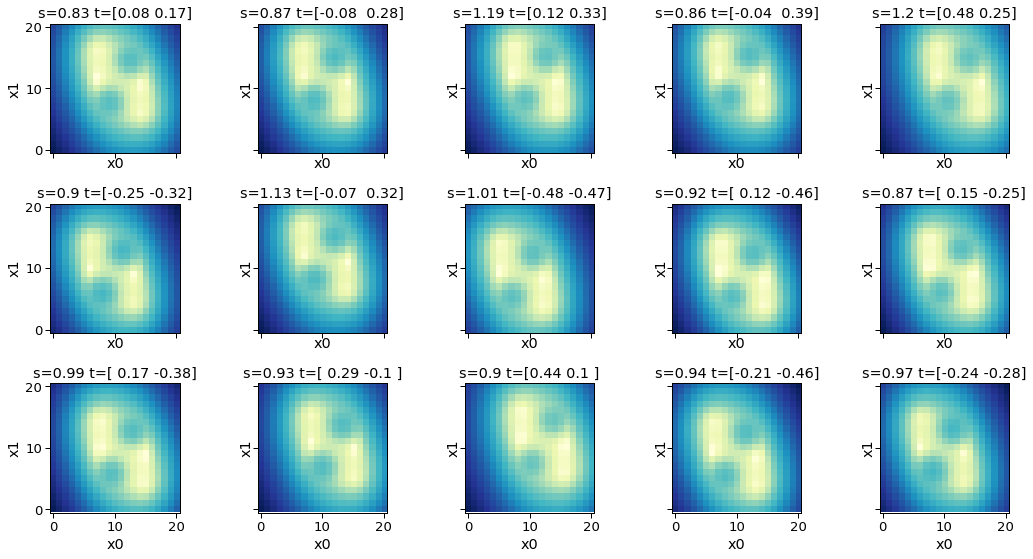

In [34]:
# PERTURBS = [
#     (-0.1, 0.9),
#     (-0.05, 0.9),
#     (0.0, 0.9),
#     (0.05, 0.9),
#     (0.1, 0.9),
#      (-0.1, 1.0),
#     (-0.05, 1.0),
#     (0.0, 1.0),
#     (0.05, 1.0),
#     (0.1, 1.0),
#     (-0.1, 1.1),
#     (-0.05, 1.1),
#     (0.0, 1.1),
#     (0.05, 1.1),
#     (0.1, 1.1),
# ]

# PERTURBS = [
#     (-0.3, 0.9),
#     (-0.15, 0.9),
#     (0.0, 0.9),
#     (0.15, 0.9),
#     (0.3, 0.9),
#      (-0.3, 1.0),
#     (-0.15, 1.0),
#     (0.0, 1.0),
#     (0.15, 1.0),
#     (0.3, 1.0),
#     (-0.3, 1.1),
#     (-0.15, 1.1),
#     (0.0, 1.1),
#     (0.15, 1.1),
#     (0.3, 1.1),
# ]

s_range = [0.8, 1.2]
t_range = [-0.5, 0.5]


num_opts = 21
surf = CatCamelVar(param_dim=2, num_opts=num_opts)

fig, axes = plt.subplots(3, 5, figsize=(15, 8), sharex=True, sharey=True)
axes = axes.flatten()

domain = np.arange(num_opts)

for ix in range(15):
    
    Z      = np.zeros((num_opts, num_opts))
    s = np.random.uniform(s_range[0], s_range[1])
    t =  np.random.uniform(t_range[0], t_range[1], size=2)
    for x_index, x in enumerate(domain):
        for y_index, y in enumerate(domain):
            Z[y_index, x_index] = np.log( surf.run_var([f'x{x}', f'x{y}'], t=t, s=s) ) 
    axes[ix].imshow(Z, origin = 'lower', cmap = plt.get_cmap('YlGnBu'))
    #axes[0].colorbar()
    axes[ix].set_title(f's={np.around(s, 2)} t={np.around(t, 2)}')
    axes[ix].set_xlabel('x0')
    axes[ix].set_ylabel('x1')


plt.tight_layout()




In [81]:
trans = OlympTransform('Dejong', 2)

trans.max_min()

(array([[0, 0],
        [0, 1],
        [1, 0],
        [1, 1]]),
 array([[4.47213595],
        [4.47213595],
        [4.47213595],
        [4.47213595]]),
 array([[0.5, 0.5]]),
 array([[0.]]))

In [82]:
x = np.array([[0.5, 0.5]])
s = trans.run(x)
print(type(s))
print(s)

<class 'numpy.ndarray'>
[[0.]]


In [9]:
PERTURBS = [
    (-0.1, 0.9),
    (-0.05, 0.9),
    (0.0, 0.9),
    (0.05, 0.9),
    (0.1, 0.9),
     (-0.1, 1.0),
    (-0.05, 1.0),
    (0.0, 1.0),
    (0.05, 1.0),
    (0.1, 1.0),
    (-0.1, 1.1),
    (-0.05, 1.1),
    (0.0, 1.1),
    (0.05, 1.1),
    (0.1, 1.1),
]

# PERTURBS = [
#     (-0.3, 0.9),
#     (-0.15, 0.9),
#     (0.0, 0.9),
#     (0.15, 0.9),
#     (0.3, 0.9),
#      (-0.3, 1.0),
#     (-0.15, 1.0),
#     (0.0, 1.0),
#     (0.15, 1.0),
#     (0.3, 1.0),
#     (-0.3, 1.1),
#     (-0.15, 1.1),
#     (0.0, 1.1),
#     (0.15, 1.1),
#     (0.3, 1.1),
# ]

x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)
features = np.dstack([X, Y]).reshape(-1, 2)

X, Y = np.meshgrid(x, y)

surf = OlympTransform('AckleyPath', 2)

z_orig = surf.run(features) 



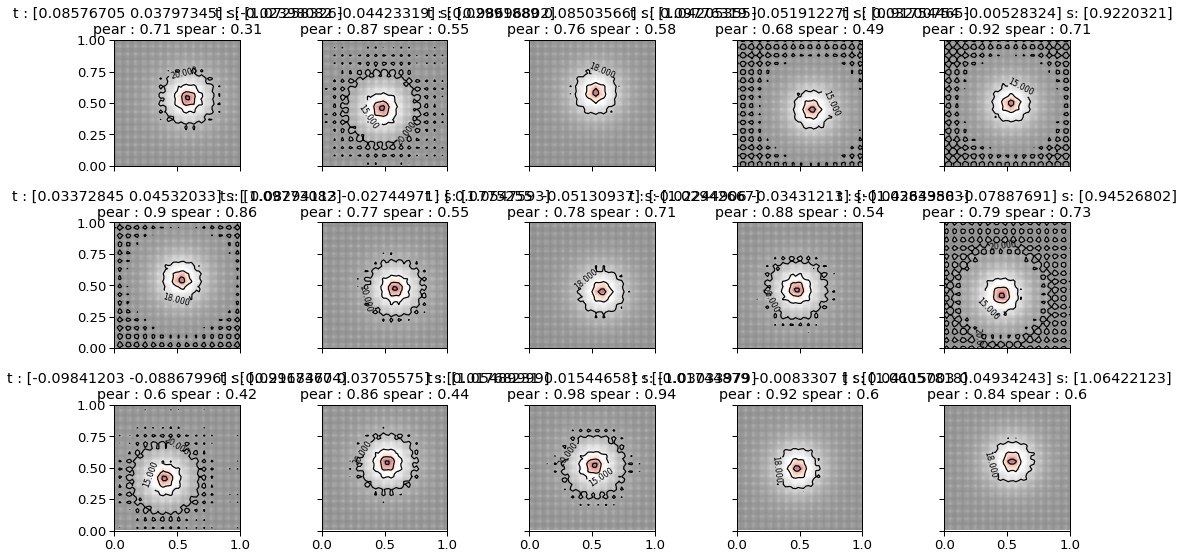

In [167]:
fig, axes = plt.subplots(3, 5, figsize=(15, 8), sharex=True, sharey=True)
axes = axes.flatten()


t_range = [-0.1, 0.1]
s_range = [0.9, 1.1]

for ix in range(15):
    
    t = np.random.uniform(t_range[0], t_range[1], size=2)
    s = np.random.uniform(s_range[0], s_range[1], size=1)
    
    z_shift = surf.var(features, t=t, s=s)
    Z = z_shift.reshape((x.shape[0], y.shape[0]))
    
    pear = pearsonr(z_shift.ravel(), z_orig.ravel())[0]
    spear = spearmanr(z_shift.ravel(), z_orig.ravel())[0]
    
    # plot the surface
    contours = axes[ix].contour(X, Y, Z, 3, colors='black')
    axes[ix].clabel(contours, inline=True, fontsize=8)
    axes[ix].imshow(Z, extent=[0, 1, 0, 1], origin='lower', cmap='RdGy', alpha=0.5)
    axes[ix].set_title(f't : {np.around(t)} s: {s}\npear : {round(pear,2)} spear : {round(spear, 2)}')
    

plt.tight_layout()

FLIP INDICES : []


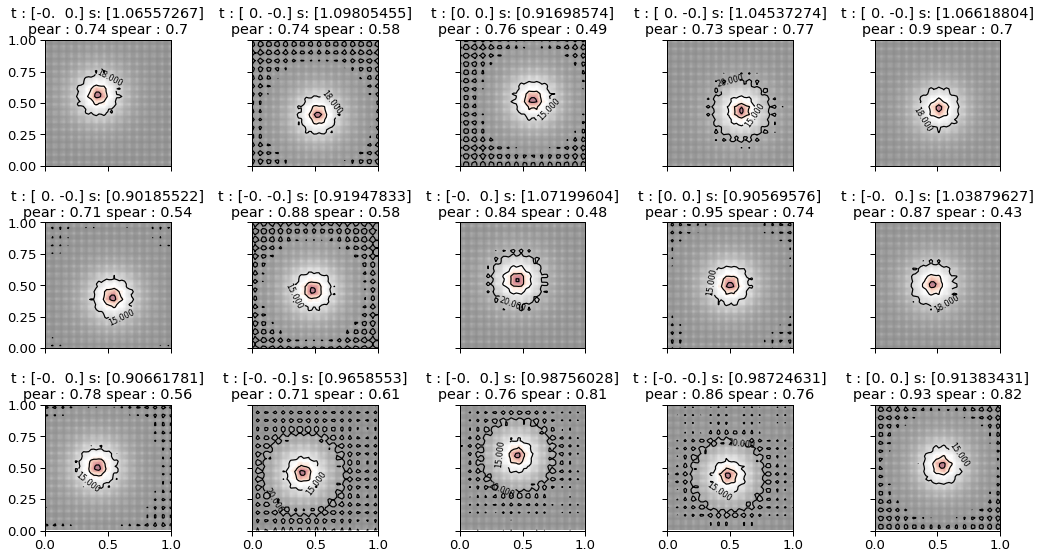

In [23]:
fig, axes = plt.subplots(3, 5, figsize=(15, 8), sharex=True, sharey=True)
axes = axes.flatten()


t_range = [-0.1, 0.1]
s_range = [0.9, 1.1]

#flip_indices = np.random.randint(0, 15, size=(7,))
flip_indices = []
print('FLIP INDICES :', flip_indices)

for ix in range(15):
    
    t = np.random.uniform(t_range[0], t_range[1], size=2)
    s = np.random.uniform(s_range[0], s_range[1], size=1)

    
    if ix in flip_indices:
        factor=-1
    else:
        factor=1
    z_shift = factor*surf.var(features, t=t, s=s)
        
    Z = z_shift.reshape((x.shape[0], y.shape[0]))
    
    pear = pearsonr(z_shift.ravel(), z_orig.ravel())[0]
    spear = spearmanr(z_shift.ravel(), z_orig.ravel())[0]
    
    # plot the surface
    contours = axes[ix].contour(X, Y, Z, 3, colors='black')
    axes[ix].clabel(contours, inline=True, fontsize=8)
    axes[ix].imshow(Z, extent=[0, 1, 0, 1], origin='lower', cmap='RdGy', alpha=0.5)
    axes[ix].set_title(f't : {np.around(t)} s: {s}\npear : {round(pear,2)} spear : {round(spear, 2)}')
    

plt.tight_layout()

## MultFonseca

In [21]:
class MultFonsecaVar(AbstractSurface):
    def __init__(self, noise=None):
        """Fonseca–Fleming function in 2 dimensions
        Fonseca, C. M.; Fleming, P. J. (1995). "An Overview of Evolutionary
        Algorithms in Multiobjective Optimization". Evol Comput. 3 (1): 1–16.

        Args:
            noise (Noise): Noise object that injects noise into the evaluations of the surface. Default is None.
        """
        param_dim = 2
        value_dim = 2
        AbstractSurface.__init__(**locals())

    @property
    def minima(self):
        # TODO: implement me
        return None
        # return [{'params': params, 'value': value}]

    @property
    def maxima(self):
        # TODO: implement me
        return None
    
    def run_var(self, vector, t, s):
        x_new = np.array(vector.copy())
        x_new = x_new - t
        tmp = self._run(x_new)
        y = [s[i]*tmp[i] for i in range(len(tmp))]
        return y


    def _run(self, params):
#         params = np.array(params)
        obj_0 = 1 - np.exp(-np.sum((params - 1.0 / np.sqrt(len(params))) ** 2))
        obj_1 = 1 - np.exp(-np.sum((params + 1.0 / np.sqrt(len(params))) ** 2))

        raw_results = [obj_0, obj_1]

        if self.noise is None:
            return raw_results
        else:
            results = []
            for result in raw_results:
                results.append(self.noise(result))
            return results


In [23]:
surf = MultFonsecaVar()
params = [0.5, 0.5]
s = surf.run_var(params, t=[0.2, 0.2], s=[1.2, 1.1])
print(s)

[0.33856037418904267, 0.9553181315500917]


## MultViennet

In [42]:
class MultViennetVar(AbstractSurface):
    def __init__(self, noise=None):
        """Viennet function

        Args:
            noise (Noise): Noise object that injects noise into the evaluations of the surface. Default is None.
        """
        param_dim = 2
        value_dim = 3
        AbstractSurface.__init__(**locals())

    @property
    def minima(self):
        # TODO: implement me
        return None
        # return [{'params': params, 'value': value}]

    @property
    def maxima(self):
        # TODO: implement me
        return None
    
    def run_var(self, vector, t, s):
        x_new = np.array(vector.copy())
        x_new = x_new - t
        tmp = self._run(x_new)
        y = [s[i]*tmp[i] for i in range(len(tmp))]
        return y

    def _run(self, params):
        params = np.array(params)
        obj_0 = 0.5 * (params[0] ** 2 + params[1] ** 2) + np.sin(
            params[0] ** 2 + params[1] ** 2
        )
        obj_1 = (
            (((3 * params[0] - 2 * params[1] + 4) ** 2) / 8)
            + (((params[0] - params[1] + 1) ** 2) / 27)
            + 15
        )
        obj_2 = (1 / (params[0] ** 2 + params[1] ** 2 + 1)) - (
            1.1 * np.exp(-(params[0] ** 2 + params[1] ** 2))
        )

        raw_results = [obj_0, obj_1, obj_2]

        if self.noise is None:
            return raw_results
        else:
            results = []
            for result in raw_results:
                results.append(self.noise(result))
            return results


In [43]:
surf = MultViennetVar()
params = [0.5, 0.5]
s = surf.run_var(params, t=[0.2, 0.2], s=[1.2, 1.1, 1.3])
print(s)

[0.322835488110989, 19.08311574074074, -0.09274148706388173]


In [13]:
PERTURBS = [
    (-0.1, 0.9),
    (-0.05, 0.9),
    (0.0, 0.9),
    (0.05, 0.9),
    (0.1, 0.9),
     (-0.1, 1.0),
    (-0.05, 1.0),
    (0.0, 1.0),
    (0.05, 1.0),
    (0.1, 1.0),
    (-0.1, 1.1),
    (-0.05, 1.1),
    (0.0, 1.1),
    (0.05, 1.1),
    (0.1, 1.1),
]

x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)
features = np.dstack([X, Y]).reshape(-1, 2)

X, Y = np.meshgrid(x, y)

z_orig = gprice(features) # original goldstein-price function


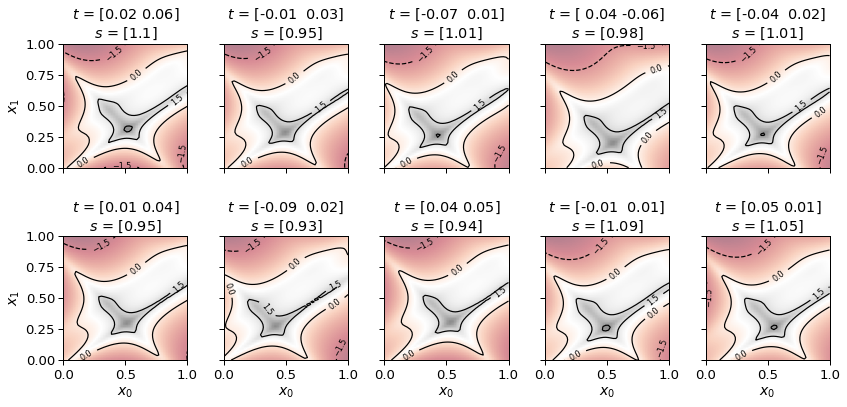

In [23]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6), sharex=True, sharey=True)
axes = axes.flatten()

t_range = [-0.1, 0.1]
s_range = [0.9, 1.1]

for ix in range(10):
    
    t = np.random.uniform(t_range[0], t_range[1], size=2)
    s = np.random.uniform(s_range[0], s_range[1], size=1)
    
    z_shift = gprice_var(features, t=t, s=s)
    Z = z_shift.reshape((x.shape[0], y.shape[0]))
    
    pear = pearsonr(z_shift.ravel(), z_orig.ravel())[0]
    spear = spearmanr(z_shift.ravel(), z_orig.ravel())[0]
    
    # plot the surface
    contours = axes[ix].contour(X, Y, Z, 3, colors='black')
    axes[ix].clabel(contours, inline=True, fontsize=8)
    axes[ix].imshow(Z, extent=[0, 1, 0, 1], origin='lower', cmap='RdGy', alpha=0.5)
    axes[ix].set_title(f'$t$ = {np.around(t,2)}\n$s$ = {np.around(s,2)}')
    
for ax in axes[5:]:
    ax.set_xlabel(r'$x_0$', fontsize=14)
    
axes[0].set_ylabel(r'$x_1$', fontsize=14)
axes[5].set_ylabel(r'$x_1$', fontsize=14)    

plt.tight_layout()

plt.savefig('gprice_perturbation_samples.png', dpi=300)


In [44]:
def metaBO_factory(
    num_samples,
    kind,
    t_range=[-0.1, 0.1],
    s_range=[0.9, 1.1],
    num_sobol=50,
    flip_indices=[],
    ):
    ''' sample perturbed funcs in metaBO paper
    
    flip_indicies --> flips the sign of the surface for the given indices
    '''
    if kind in ['bra', 'gprice']:
        param_dim=2
        value_dim=1
    elif kind == 'hm3':
        param_dim=3
        value_dim=1
    elif kind == 'AckleyPath':
        param_dim=3
        value_dim=1
        surf = OlympTransform('AckleyPath', param_dim)
    elif kind == 'multfonseca':
        param_dim=2
        value_dim=2
        surf = MultFonsecaVar()
    elif kind == 'multviennet':
        param_dim=2
        value_dim=3
        surf = MultViennetVar()
        
        
    domain = sobol_seq.i4_sobol_generate(param_dim, num_sobol)
    tasks = []
    for sample_ix in range(num_samples):
        t = np.random.uniform(t_range[0], t_range[1], size=param_dim)
        s = np.random.uniform(s_range[0], s_range[1], size=value_dim)
        if kind == 'bra':
            z = bra_var(domain, t, s)
        elif kind == 'gprice':
            z = gprice_var(domain, t, s)
        elif kind == 'hm3':
            z = hm3_var(domain, t, s)
        elif kind == 'AckleyPath':
            z = surf.var(domain, t, s)
        elif kind == 'multfonseca':
            z = np.array([surf.run_var(d, t, s) for d in domain])
        elif kind == 'multviennet':
            z = np.array([surf.run_var(d, t, s) for d in domain])
        if sample_ix in flip_indices:
            z = -z
            

        tasks.append({'params': domain, 'values': z, 's': s, 't': t})

    return tasks

In [38]:
multfonseca_tasks = metaBO_factory(
    num_samples=30,
    kind='multfonseca',
    num_sobol=50
)


In [39]:
pickle.dump(multfonseca_tasks, open('mult_fonseca_2D_tasks.pkl', 'wb'))

In [37]:
# multfonseca_tasks[0]['params'].shape, multfonseca_tasks[0]['values'].shape

((50, 2), (50, 2))

In [46]:
multviennet_tasks = metaBO_factory(
    num_samples=30,
    kind='multviennet',
    num_sobol=50
)

In [47]:
pickle.dump(multviennet_tasks, open('mult_viennet_2D_tasks.pkl', 'wb'))

In [45]:
# generate data for the 2d goldstien-price experiments

gprice_tasks = metaBO_factory(
    num_samples=30,
    kind='gprice',
    num_sobol=50
)

In [46]:
pickle.dump(gprice_tasks, open('gprice_2D_tasks.pkl', 'wb'))

In [47]:
# generate data for the 3d hartmann experiments

hm3_tasks = metaBO_factory(
    num_samples=30,
    kind='hm3',
    num_sobol=200
)

In [48]:
pickle.dump(hm3_tasks, open('hartmann_3D_tasks.pkl', 'wb'))

In [49]:
# generate data for the 3d ackley path tests

ackley_tasks = metaBO_factory(
    num_samples=30,
    kind='AckleyPath',
    num_sobol=200,
)

In [50]:
pickle.dump(ackley_tasks, open('ackleypath_3D_tasks.pkl', 'wb'))

In [ ]:
# Generate categorical tasks


In [10]:
# helper functions
def int_to_hot(sample, num_opts):
    ''' Converts integer samples to one hot encoded vector. 
    Sample expects the form [i, j], where i and j are integers
    '''
    hots = []
    for s in sample:
        hot = np.zeros(num_opts)
        hot[s] += 1.
        hots.append(hot)
    hots = np.concatenate(hots, axis=0)
    assert hots.shape[0] == num_opts*len(sample)
    return hots

In [15]:
# CATCAMEL_DEBUG (super similar surfaces)
s_range = [0.8, 1.2]
t_range = [-0.1, 0.1]

num_source_tasks = 30
num_samples = 50

num_opts = 21
surf = CatCamelVar(param_dim=2, num_opts=num_opts)

catcamel_debug_tasks = []

for task_ix in range(num_source_tasks):
    
    domain = [np.random.randint(0, num_opts, size=(2,)) for _ in range(num_samples)]
    
    values = []
    t = np.random.uniform(t_range[0], t_range[1], size=2)
    s = np.random.uniform(s_range[0], s_range[1], size=1)
    for x0, x1 in domain:
            values.append(np.log( surf.run_var([f'x{x0}', f'x{x1}'], t=t, s=s) )) 
    
    assert len(values)==num_samples
    
    # get ohe params
    params = []
    for int_ in domain:
        hot = int_to_hot(int_, num_opts)
        #print(hot.shape)
        params.append(hot)
    params = np.array(params)
    #print(params.shape)
    
    values = np.array(values).reshape(-1, 1)
    
    catcamel_debug_tasks.append({'params': params, 'values': values, 's': s, 't': t})


In [16]:
pickle.dump(catcamel_debug_tasks, open('catcamel_2D_debug_tasks.pkl', 'wb'))

In [17]:
# CATMICHALEWICZ_DEBUG (super similar surfaces)
s_range = [0.8, 1.2]
t_range = [-0.1, 0.1]

num_source_tasks = 30
num_samples = 50

num_opts = 21
surf = CatMichalewiczVar(param_dim=2, num_opts=num_opts)

catmich_debug_tasks = []

for task_ix in range(num_source_tasks):
    
    domain = [np.random.randint(0, num_opts, size=(2,)) for _ in range(num_samples)]
    
    values = []
    t = np.random.uniform(t_range[0], t_range[1], size=2)
    s = np.random.uniform(s_range[0], s_range[1], size=1)
    for x0, x1 in domain:
            values.append(surf.run_var([f'x{x0}', f'x{x1}'], t=t, s=s) ) 
    
    assert len(values)==num_samples
    
    # get ohe params
    params = []
    for int_ in domain:
        hot = int_to_hot(int_, num_opts)
        #print(hot.shape)
        params.append(hot)
    params = np.array(params)
    #print(params.shape)
    
    values = np.array(values).reshape(-1, 1)
    
    catmich_debug_tasks.append({'params': params, 'values': values, 's': s, 't': t})


In [18]:
pickle.dump(catmich_debug_tasks, open('catmichalewicz_2D_debug_tasks.pkl', 'wb'))

In [19]:
# CATCAMEL 
s_range = [0.8, 1.2]
t_range = [-0.3, 0.3]

num_source_tasks = 30
num_samples = 50

num_opts = 21
surf = CatCamelVar(param_dim=2, num_opts=num_opts)

catcamel_tasks = []

for task_ix in range(num_source_tasks):
    
    domain = [np.random.randint(0, num_opts, size=(2,)) for _ in range(num_samples)]
    
    values = []
    t = np.random.uniform(t_range[0], t_range[1], size=2)
    s = np.random.uniform(s_range[0], s_range[1], size=1)
    for x0, x1 in domain:
            values.append(np.log( surf.run_var([f'x{x0}', f'x{x1}'], t=t, s=s) )) 
    
    assert len(values)==num_samples
    
    # get ohe params
    params = []
    for int_ in domain:
        hot = int_to_hot(int_, num_opts)
        #print(hot.shape)
        params.append(hot)
    params = np.array(params)
    #print(params.shape)
    
    values = np.array(values).reshape(-1, 1)
    
    catcamel_tasks.append({'params': params, 'values': values, 's': s, 't': t})


In [20]:
pickle.dump(catcamel_tasks, open('catcamel_2D_tasks.pkl', 'wb'))

In [21]:
# CATMICHALEWICZ 
s_range = [0.8, 1.2]
t_range = [-0.3, 0.3]

num_source_tasks = 30
num_samples = 50

num_opts = 21
surf = CatMichalewiczVar(param_dim=2, num_opts=num_opts)

catmich_tasks = []

for task_ix in range(num_source_tasks):
    
    domain = [np.random.randint(0, num_opts, size=(2,)) for _ in range(num_samples)]
    
    values = []
    t = np.random.uniform(t_range[0], t_range[1], size=2)
    s = np.random.uniform(s_range[0], s_range[1], size=1)
    for x0, x1 in domain:
            values.append(surf.run_var([f'x{x0}', f'x{x1}'], t=t, s=s) ) 
    
    assert len(values)==num_samples
    
    # get ohe params
    params = []
    for int_ in domain:
        hot = int_to_hot(int_, num_opts)
        #print(hot.shape)
        params.append(hot)
    params = np.array(params)
    #print(params.shape)
    
    values = np.array(values).reshape(-1, 1)
    
    catmich_tasks.append({'params': params, 'values': values, 's': s, 't': t})


In [22]:
pickle.dump(catmich_tasks, open('catmichalewicz_2D_tasks.pkl', 'wb'))

In [15]:
#-----------------------------------------------
# 3d Ackley path surfaces with ~ half reflected
#-----------------------------------------------

flip_indices = np.arange(14).tolist()

ackley_tasks_flip = metaBO_factory(
    num_samples=30,
    kind='AckleyPath',
    num_sobol=200,
    flip_indices=flip_indices,
)

In [19]:
pickle.dump(ackley_tasks_flip, open('ackleypath_3D_tasks_half_half.pkl', 'wb'))

In [37]:
#-------------------------------
# 3d ackley path noise surfaces
#-------------------------------

# should be virtually no correlation with the true surfaces
# we sample the source tasks from a GP (RBF kernel)

x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
z = np.linspace(0, 1, 20)
X, Y, Z = np.meshgrid(x, y, z)
features = np.dstack([X, Y, Z]).reshape(-1, 3)

surf = OlympTransform('AckleyPath', 3)

z_orig = surf.run(features) 

# build the GP mdoel
kernel = GPy.kern.RBF(input_dim=3, lengthscale=0.4)

mu = np.zeros((8000))
C = kernel.K(features, features)

gp_z = np.random.multivariate_normal(mu, C, 30)


# fig, axes = plt.subplots(3, 5, figsize=(15, 8), sharex=True, sharey=True)
# axes = axes.flatten()

# for ix in range(15):
    
#     gp_Z = gp_z[ix].reshape((x.shape[0], y.shape[0]))
    
#     pear = pearsonr(gp_z[ix].ravel(), z_orig.ravel())[0]
#     spear = spearmanr(gp_z[ix].ravel(), z_orig.ravel())[0]
    
#     # plot the surface
#     contours = axes[ix].contour(X, Y, gp_Z, 3, colors='black')
#     axes[ix].clabel(contours, inline=True, fontsize=8)
#     axes[ix].imshow(gp_Z, extent=[0, 1, 0, 1], origin='lower', cmap='RdGy', alpha=0.5)
#     axes[ix].set_title(f'pear : {round(pear,2)} spear : {round(spear, 2)}')
    
# plt.tight_layout()


    
    

In [38]:
ackley_3d_noise_tasks = []
num_sobol = 200

for ix in range(30):
    
    gp_z_task = gp_z[ix].reshape(-1, 1)

    indices = np.arange(gp_z_task.shape[0])
    np.random.shuffle(indices)
    
    
    feat = features[indices[:num_sobol], :]
    vals = gp_z_task[indices[:num_sobol], :]
    
    print(feat.shape, vals.shape)
    
    ackley_3d_noise_tasks.append(
        {
            'params': feat,
            'values': vals,
        }
    )

(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)
(200, 3) (200, 1)


In [39]:
pickle.dump(ackley_3d_noise_tasks, open('ackleypath_3D_tasks_noise.pkl', 'wb')) 